# **EXPANSE**

EXPANSE (EX-tended Pixel ANalysis of SEDs) is a Python package for spatially resolved SED fitting and analysis. This notebook demonstrates the basics of how to create an EXPANSE ResolvedGalaxy object, load data, and fit the SEDs of individual pixels.

I assume if you have a copy of this notebook that you have cloned the EXPANSE repository. If not, you can install it using pip: - run pip install . in the root directory of the repository. Add -e if you want to install it in editable mode.


Firstly we will import some neccessary packages.

In [9]:
import astropy.units as u
import numpy as np
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt

from EXPANSE import ResolvedGalaxy
from EXPANSE.utils import FieldInfo, PhotometryBandInfo

%matplotlib inline

There are two ways to create a new ResolvedGalaxy object. The first is to create it directly from a galfind Galaxy object, which is a class from the [galfind package](https://galfind.readthedocs.io/en/latest/). The second is to create it from scratch, which is what we will do here.

To that end, we have imported PhotometryBandInfo and FieldInfo from the EXPANSE.utils directory. These are helper classes designed to make it easier to pass the information about the photometry bands and fields to the ResolvedGalaxy object.

Firstly we will define some basic information about the galaxy. We will give it a ID, and a survey or field name, and a redshift. We will define a position using an astropy SkyCoord object. We will list the available photometric bands by the filter designation, but this is primarily for our convenience at this stage.

Our test galaxy is in the JOF field, and we will incorporate both the HST and NIRCam imaging data.

In [2]:
galaxy_id = '16'
survey = 'JOF'
redshift = 4.5464916
ra = 53.0491711 # deg
dec = -27.9017415 # deg
cutout_size = 70 # pixels # 'auto' is in development to base on the segmentation map. 

position = SkyCoord(ra = ra * u.deg, dec = dec * u.deg)

hst_bands = ['F435W', 'F606W' ,'F775W', 'F814W', 'F850LP']
nircam_bands = ['F090W', 'F115W', 'F150W', 'F162M', 'F182M', 'F200W', 'F210M',
                'F250M', 'F277W', 'F300M', 'F335M', 'F356W', 'F410M', 'F444W']


Now we will initialize some PhotometryBandInfo objects. The goal is to have one photometry band object for each filter in the survey, which links together the band name, image file, image file, segmentation map (if it exists) and other information.

The path provided can either be a direct path to the image, or to the parent directory of the image. If the path is to the parent directory, the code will search for the image file in that directory, and will print the file it finds. You can link one path to another by e.g. setting err_path = 'im_folder' below, which will search for the error image in the same directory as the main image. If you set err_path = None, the code will not search for an error image. If you set err_path = 'im', the code will search for an ERR extension in the same file as the main image.

The code will attempt to determine the zeropoint, image unit and pixel scale of the image from the header, but you can override this by setting the values manually.

Pay careful attention to the print statements, as they will tell you if the code is unable to find the image file, or if it is unable to determine the zeropoint, image unit or pixel scale. The code may make an assumption about the naming convention or header information of the image file, and if this assumption is incorrect, you will need to set the values manually.

Note that the below code is setup to load in my own data, and you will need to change the paths to the image files to match your own data.

In [3]:
galaxy_info = []
# Add HST bands
for band in hst_bands:
    band_info = PhotometryBandInfo(band_name=band, survey=survey,
                                image_path = f'/raid/scratch/data/hst/{survey}/ACS_WFC/mosaic_1084_wispnathan/30mas/',
                                wht_path = 'im_folder',
                                err_path = f'/raid/scratch/data/hst/{survey}/ACS_WFC/mosaic_1084_wispnathan/30mas/rms_err/',
                                seg_path = f'/raid/scratch/work/austind/GALFIND_WORK/SExtractor/ACS_WFC/v11/{survey}/MAP_RMS/segmentation/{survey}_{band}_{band}_sel_cat_v11_seg.fits',
                                err_hdu_ext = 1,
                                psf_path = '/nvme/scratch/work/tharvey/PSFs/JOF/', # optional
                                psf_type = 'star_stack', # optional
    )
    galaxy_info.append(band_info)

# Now add NIRCam bands
for band in nircam_bands:
    band_info = PhotometryBandInfo(band_name=band, survey=survey,
                                    image_path = f'/raid/scratch/data/jwst/{survey}/NIRCam/mosaic_1084_wispnathan/',
                                    wht_path = 'im',
                                    err_path = 'im',
                                    seg_path =f'/raid/scratch/work/austind/GALFIND_WORK/SExtractor/NIRCam/v11/{survey}/MAP_RMS/segmentation/{survey}_{band}_{band}_sel_cat_v11_seg.fits',
                                    psf_path = '/nvme/scratch/work/tharvey/PSFs/JOF/', # optional
                                    psf_type = 'star_stack', # optional
    )

    galaxy_info.append(band_info)



Auto detected weight path /raid/scratch/data/hst/JOF/ACS_WFC/mosaic_1084_wispnathan/30mas/ACS_WFC_F435W_JOF_wht.fits for band F435W.
Auto detected error path /raid/scratch/data/hst/JOF/ACS_WFC/mosaic_1084_wispnathan/30mas/rms_err/F435W_rms_err.fits for band F435W.
Auto detected PSF path /nvme/scratch/work/tharvey/PSFs/JOF/F435W_psf.fits for band F435W.
Auto detected image path /raid/scratch/data/hst/JOF/ACS_WFC/mosaic_1084_wispnathan/30mas/ACS_WFC_F435W_JOF_drz.fits for band F435W.
Auto detected zero point 25.68 with keyword ZEROPNT for band F435W.
Auto detected unit ELECTRONS/S with keyword BUNIT for band F435W.
Both zero point and unit found for band F435W. Using ZP 25.68.
Auto detected pixel scale 0.0300 arcsec arcsec/pixel from WCS for band F435W.
Auto detected weight path /raid/scratch/data/hst/JOF/ACS_WFC/mosaic_1084_wispnathan/30mas/ACS_WFC_F606W_JOF_wht.fits for band F606W.
Auto detected error path /raid/scratch/data/hst/JOF/ACS_WFC/mosaic_1084_wispnathan/30mas/rms_err/F606W_rm

Note that there is a lot more info we could provide above if desired - previously measured photometry, both PSF matched images and raw images etc.

Now we combine these PhotometryBandInfo objects into a list, and create a FieldInfo object. This object contains the information about the field, including the photometry bands, the segmentation map, and the pixel scale of the image.

Notice if we print the FieldInfo object we get a summary of the information we have provided.

In [4]:
# Make a FieldInfo object
field_info = FieldInfo(galaxy_info)

print(field_info)

Field Info for Survey: JOF
Band    Instrument  Pixel Scale   ZP/Unit  PSF Matched  PSF Type    Err  Wht  Seg  PSF  PSF Kernel  Auto Phot  Aper Phot  
--------------------------------------------------------------------------------------------------------------------------
F435W   auto        0.030 arcsec  25.68    No           star_stack  Yes  Yes  Yes  Yes  No          No         No         
F606W   auto        0.030 arcsec  26.51    No           star_stack  Yes  Yes  Yes  Yes  No          No         No         
F775W   auto        0.030 arcsec  25.69    No           star_stack  Yes  Yes  Yes  Yes  No          No         No         
F814W   auto        0.030 arcsec  25.94    No           star_stack  Yes  Yes  Yes  Yes  No          No         No         
F850LP  auto        0.030 arcsec  24.87    No           star_stack  Yes  Yes  Yes  Yes  No          No         No         
F090W   auto        0.030 arcsec  28.087   No           star_stack  Yes  Yes  Yes  Yes  No          No         N

We can then create a ResolvedGalaxy object, which will create the galaxy cutouts and store all provided information in a portable HDF5 file. This file can be loaded later to continue the analysis.

There are a number of other arguments you may wish to set. These are:

- **forced_phot_band**: If you want to perform forced photometry on a specific band, set this to the filter name (or list for an inverse variance weighted combination of bands).

- **dont_psf_match_bands**: If you do not want to match the PSF between certain bands, set this to a list of the filter names. This is useful if the PSF matching is not working well for certain bands or PSF models are not available.


In [ ]:
galaxy = ResolvedGalaxy.init_from_basics(galaxy_id = galaxy_id,
                                        field_info = field_info,
                                        survey = survey,
                                        cutout_size=cutout_size,
                                        sky_coord=position,
                                        redshift = redshift)

We can use the returned object directly, or load it from the HDF5 file. The HDF5 filenames generally have the format 'fieldname_galaxyid.hdf5', but you can specify a different filename if you wish.

In [2]:
galaxy = ResolvedGalaxy.init_from_h5('JOF_16.h5')

There are many methods available on a ResolvedGalaxy, but we will go over the most important ones here.

### Plotting Cutouts

Firstly, we can plot the galaxy cutouts. This will show the galaxy cutouts for each band. 

It's worth noting that you can do ?galaxy.method to get the docstring for that method.

In [12]:
?galaxy.plot_cutouts

Signature:
galaxy.plot_cutouts(
    bands=None,
    psf_matched=False,
    save=False,
    psf_type=None,
    save_path=None,
    show=False,
    facecolor='white',
    fig=None,
    cmap='viridis',
    stretch='log',
)
Docstring: Plot the cutouts for the galaxy
File:      /nvme/scratch/work/tharvey/EXPANSE/src/EXPANSE/ResolvedGalaxy.py
Type:      method

We could change the cmap, stretch, or bands to plot. All plotting methods also typically take a figure and axis argument, so you can plot to a specific figure or axis if you wish to build up a more complex plot. We can also plot the PSF matched image in all bands if we prefer.

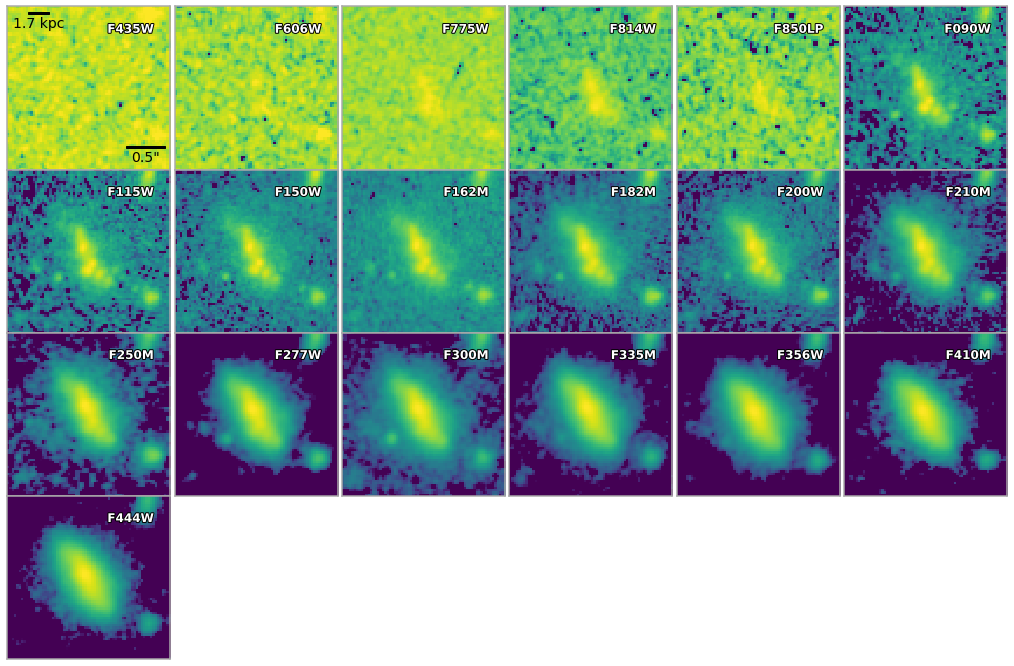

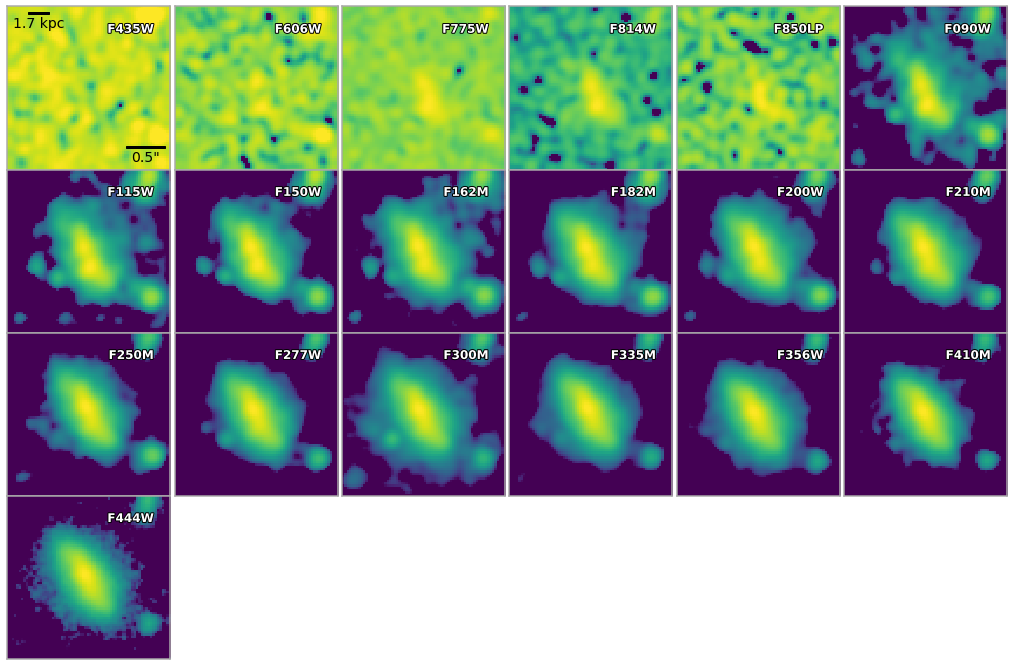

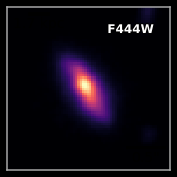

In [3]:
%matplotlib inline
galaxy.plot_cutouts();
galaxy.plot_cutouts(psf_matched=True);
galaxy.plot_cutouts(bands=['F444W'], cmap='magma', stretch='linear', facecolor='black');

There are also functions to plot the segmentation map and RMS error map, but these are really just wrappers around the plot_cutouts function, and you can change the data argument to "seg" or "rms_err" to achieve the same effect.

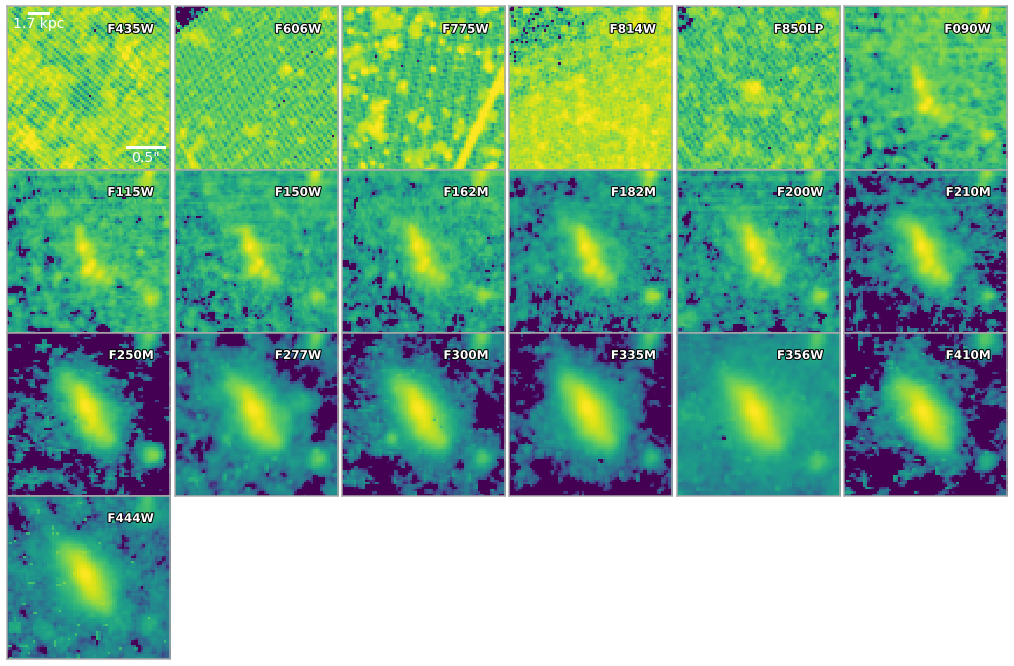

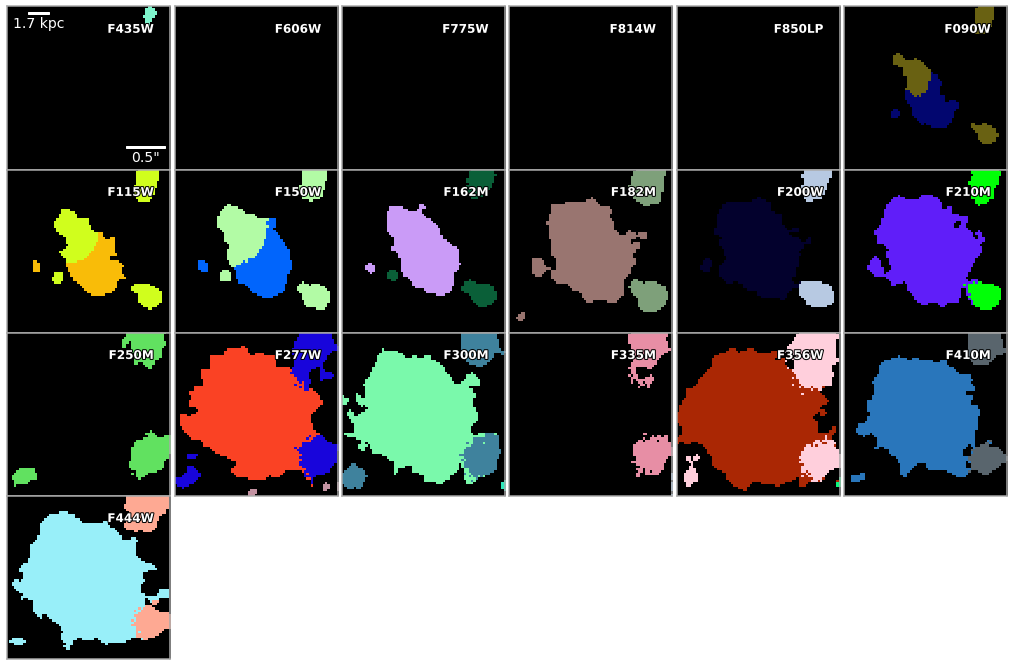

In [4]:
%matplotlib inline
galaxy.plot_err_cutouts();

galaxy.plot_seg_cutouts();

### Plotting an RGB

There is a function for plotting RGB images, with many options. By default it plots nothing, 
but if you pass in a list of bands for red, green, and blue respectively, it will plot the RGB image.
You can pass a single band, or a list of bands, which will be combined according to the combine_func argument (np.sum by default).

You can also add a scalebar or a compass, set your own figure or axis, change the stretch, label the bands used and many other options.

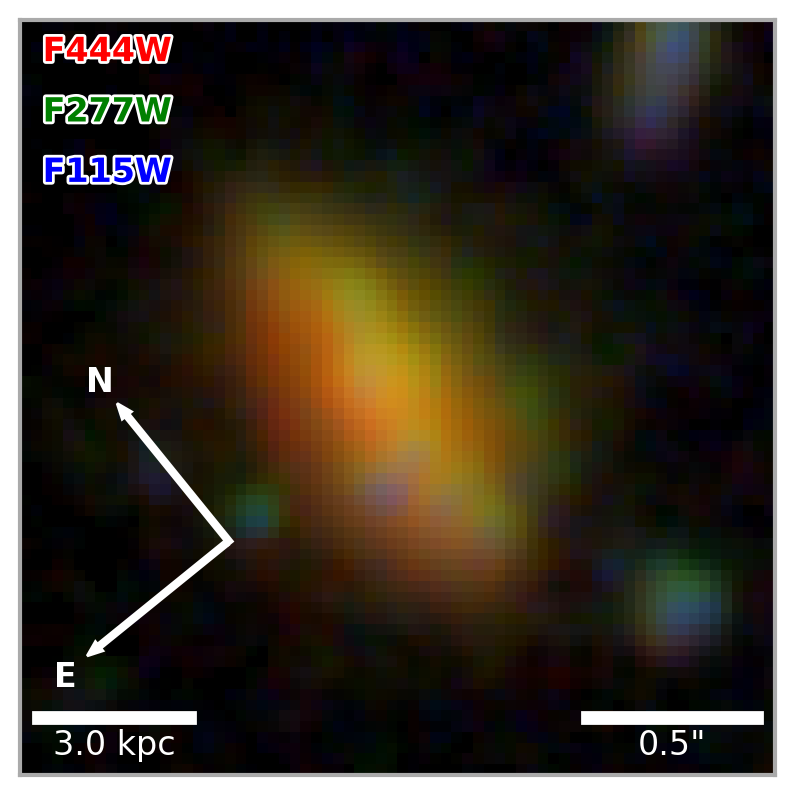

In [25]:
%matplotlib inline
galaxy.plot_lupton_rgb(show=True, figsize=(5, 5), 
                return_array=False, red=['F444W'], green=['F277W'], blue=['F115W'],
                compass_center=(18, 20),  stretch = 1e-3, q = 10,
                use_psf_matched=False,
                add_compass=True, add_scalebar=True, label_bands=True)

Saving info to .h5. Generally this will happen automatically, but if you want to force a save, you can call the dump_to_h5 method. If you aren't sure if a particualr parameter has been saved (normally anything added to the .h5 is printed in the output) then call this method to be sure. 

In order to allow deletion of items from the file and to present the file sizes ballooning, the .h5 file is not overwritten, but rather a new file is created with the same name which replaces the old file. The serialization is currently rather manual, such that new arguments are not automatically added to the .h5 file, but anything that is added (see below for an example of the add_to_h5 function) will be copied over to the new file. This can be turned off by setting copy_from_old=False in the dump_to_h5 function.

We recommend the [H5Web](https://github.com/silx-kit/vscode-h5web) extension for VSCode for viewing the contents of the .h5 file, or [h5forest](https://github.com/WillJRoper/h5forest) for a command line HDF5 viewer.

In [35]:
galaxy.dump_to_h5()

Signature:
galaxy.dump_to_h5(
    h5_folder='/nvme/scratch/work/tharvey/EXPANSE/galaxies/',
    mode='append',
    force=False,
    copy_from_old=True,
)
Docstring: Dump the galaxy data to an .h5 file
File:      /nvme/scratch/work/tharvey/EXPANSE/src/EXPANSE/ResolvedGalaxy.py
Type:      method

You can add your own data to the .h5 file using the add_to_h5 method. This will add a new dataset to the file, which can be accessed later. 

In [36]:
galaxy.add_to_h5(original_data=data_array, group='new_data', name='exciting_results',
                setattr_gal = 'new_results', meta = {'key1': 'value1', 'key2': 'value2'})

Signature:
galaxy.add_to_h5(
    original_data,
    group,
    name,
    ext=0,
    setattr_gal=None,
    overwrite=False,
    meta=None,
    setattr_gal_meta=None,
    force=False,
)
Docstring: <no docstring>
File:      /nvme/scratch/work/tharvey/EXPANSE/src/EXPANSE/ResolvedGalaxy.py
Type:      method

### PSF Matching

If you didn't provide your PSF models or initializtion, or want to add more (you can store multiple cutouts with different models in the same file), there are methods to do this.

In [ ]:
galaxy.add_psf_models(psf_dir = '/nvme/scratch/work/tharvey/PSFs/JOF/', psf_type='star_stack')

You can also directly generate WebbPSF models for JWST instruments as well if you have webbpsf installed. The code will attempt to match the wavefront calibration of the PSF model to each image and the PSF location to the galaxy location within the image (this only works for single NIRCam pointings, otherwise the information is lost.) By default the jitter_sigma parameters of Morishita+2023 are set in order to produce more realistic PSFs.

In [ ]:
galaxy.get_webbpsf(fov=4, oversample=6)

If you have an empirial PSF model you made with the script in psfs/make_psf.py can load it using the galaxy.get_star_stack_psf method. Typically the code is looking for a file structure like psfs/psf_name/survey_name/.

In [ ]:
galaxy.get_star_stack_psf(match_band='F444W', name="star_stack", overwrite=False)

Typically the above methods will build the convolution kernels, but you can also do this manually if you have added your PSFs manually.

In [ ]:
galaxy.convert_psfs_to_kernels(psf_type='simulated', psf_dir='/path/to/psf/model/')

You can convolve these models with the images using the convovle_with_psf method, which will store the convolved images in the HDF5 file.

In [ ]:
psf_type = 'webbpsf'
galaxy.convolve_with_psf(psf_type=psf_type)

### Source Detection and Photometry with SEP (SExtractor for Python)

If you have just got basic cutouts of an object of interest, you might want to measure aperture/kron photometry, or otherwise detect sources in the image. We have a method for this, which will use the SEP package to detect sources in the image, and then measure photometry for each source. We specifally recommend sep_pjw as it is actively maintained and has a number of improvements over the original sep package.

You can choose which band(s) are used for detection - if you pass a list they will be combined
in an inverse variance weighted stack. 

You can set many of the common SEXtractor parameters, such as the detection threshold, the minimum number of pixels in a source, the deblending threshold and contrast, and the aperture radii. You can also directly pass in a convolution kernel to convolve the image with before detection, the default is a Gaussian kernel with a FWHM of 2.5 pixels.

You can set whether the results are saved or just returned. By default, if overwrite is set to False, 
sep will only be run to add photometry types that are missing from the H5 file. E.g. if you loaded aperture photometry, but not auto photometry, it will only run sep to get the auto photometry. If you set overwrite to True, it will rerun sep for all photometry types. 

The available photometry types include aperture photometry, Kron photometry (MAG_AUTO, MAG_ISO, etc), 
segmentation map generation, seperate storage of detection photometry/segmentation map, and 'total photometry', which is probably the most robust none aperture photometry method, as the Kron parameters are determined from the detection image, and a consistent Kron ellipse is used for all bands, and a Kron specific aperture correction is determined from the PSF models.

It's worth mentioning that the uncertanties generated by sep may be underestimated due to correlated noise in the images. You can set a noise floor when SED fitting, or scale the uncertanties by a factor in the measure_photometry function, which is a prerequisite for SED fitting.

In [3]:
galaxy.sep_process(overwrite=True)

Running for ['aperture', 'auto', 'seg', 'det_data', 'total_photometry']
Found 3 objects in detection band F277W+F356W+F444W
Assuming F277W+F356W+F444W is detection band.
Ratio is 1.523


This doesn't look like it's done a lot, but in reality a lot more information has been stored in the HDF5 file.

In [7]:
print(galaxy.total_photometry)
print(galaxy.aperture_photometry)
print(galaxy.det_data)
print(galaxy.auto_photometry)

{'F435W': {'flux': -0.005822449761490514, 'flux_err': 0.002546685210430941, 'flux_unit': 'uJy'}, 'F606W': {'flux': 0.012278901789383938, 'flux_err': 0.0019319106760888542, 'flux_unit': 'uJy'}, 'F775W': {'flux': 0.05064608307317805, 'flux_err': 0.003572918081179341, 'flux_unit': 'uJy'}, 'F814W': {'flux': 0.05663046574498606, 'flux_err': 0.0017851330632088025, 'flux_unit': 'uJy'}, 'F850LP': {'flux': 0.07986568998396162, 'flux_err': 0.004904349832126217, 'flux_unit': 'uJy'}, 'F090W': {'flux': 0.08328408841813854, 'flux_err': 0.0007765222563697132, 'flux_unit': 'uJy'}, 'F115W': {'flux': 0.10146795186363333, 'flux_err': 0.000737095898581697, 'flux_unit': 'uJy'}, 'F150W': {'flux': 0.14801603950550576, 'flux_err': 0.0005523307892331273, 'flux_unit': 'uJy'}, 'F162M': {'flux': 0.16496186307006436, 'flux_err': 0.000676970391965483, 'flux_unit': 'uJy'}, 'F182M': {'flux': 0.1915505656707416, 'flux_err': 0.0005003447212784984, 'flux_unit': 'uJy'}, 'F200W': {'flux': 0.24766767809473633, 'flux_err': 

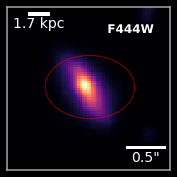

In [5]:
%matplotlib inline
galaxy.plot_cutouts(bands=['F444W'], cmap='magma', stretch='linear', facecolor='black', plot_kron=True);

### Noise Analysis

Flux uncertanties estimated by e.g. sep, or from naive error propagation of different bins can underestimate the true uncertainity due to correlated noise present in the image, as a consequence of the drizzling/resampling/PSF matching processes.

Empriically measuring this underestimation is important for accurate flux uncertanties for a resolved analysis.

EXPANSE provides a few methods to estimate this. Firstly, there is the derive_rms_correction_factor method, which calculates the correction factor between a naive error estimation from photutils and a true uncertaity as derived from empty apertures placed in the image. Due to the ununiform size of possible bins, we estimate the correction factor as a function of area rather than the exact shape of the binned region. Linear interpolation between the radii tested is used to calculate a correction factor. 

The GALFIND module is used to calculate the local depths efficiently, from a larger region surrounding the galaxy cutout which can be set in the arguments. 

NOTE: Only one version of this correction factor is stored, so if have already run this and change a parameter, it won't be applied unless overwrite=True.

Calculating depths.:   0%|          | 0/3 [00:00<?, ?it/s]

{'minx': 7327.0707924004455, 'maxx': 9327.070792400445, 'miny': -755.0996902030197, 'maxy': 1244.9003097969803}
Cutout size: 2000, Image size: (10244, 4464), vals: {'minx': 7327.0707924004455, 'maxx': 9327.070792400445, 'miny': 0, 'maxy': 1244.9003097969803}
Reading GALFIND config file from: /nvme/scratch/work/tharvey/galfind/galfind/../configs/galfind_config.ini


32890it [00:05, 5534.06it/s]
32890it [00:06, 5403.29it/s]
32890it [00:06, 5409.91it/s]
32890it [00:06, 4853.43it/s]
21692it [00:03, 5481.79it/s]
21692it [00:04, 5012.81it/s]
21692it [00:04, 4637.35it/s]
21692it [00:04, 4729.91it/s]
15386it [00:02, 5236.31it/s]
15386it [00:03, 4687.83it/s]
15386it [00:03, 4819.18it/s]
15386it [00:03, 4624.75it/s]
11424it [00:02, 5604.91it/s]
11424it [00:02, 4210.59it/s]
11424it [00:02, 4188.79it/s]
11424it [00:02, 4614.86it/s]
8806it [00:01, 5068.14it/s]
8806it [00:01, 4680.53it/s]
8806it [00:01, 4883.03it/s]
8806it [00:01, 4500.86it/s]


7062it [00:01, 5421.01it/s]
7062it [00:01, 4609.66it/s]
7062it [00:01, 4718.25it/s]
7062it [00:01, 4610.77it/s]


5760it [00:01, 5203.52it/s]
5760it [00:01, 4240.64it/s]
5760it [00:01, 4343.58it/s]
5760it [00:01, 3563.81it/s]


4752it [00:01, 4316.12it/s]
4752it [00:01, 4159.33it/s]
4752it [00:01, 4186.50it/s]
4752it [00:01, 4153.81it/s]


4050it [00:00, 4683.81it/s]
4050it [00:00, 4545.70it/s]
4050it [00:00, 4130.74it/s]
4050it [00:01, 3939.72it/s]


3404it [00:00, 4367.87it/s]
3404it [00:00, 4128.78it/s]
3404it [00:00, 4050.87it/s]
3404it [00:00, 4631.75it/s]


2600it [00:00, 4022.04it/s]
2600it [00:00, 3884.47it/s]
2600it [00:00, 3480.28it/s]
2600it [00:00, 3847.19it/s]
Calculating depths.:  33%|███▎      | 1/3 [01:54<03:48, 114.14s/it]

Setting meta, scatter_size, 0.1
Setting meta, distance_to_mask, 30
Setting meta, n_nearest, 5000
Setting meta, cutout_size, 2000
 added to <HDF5 file "JOF_16.h5" (mode r+)>, rms_correction_factors, F277W
{'minx': 7327.0707924004455, 'maxx': 9327.070792400445, 'miny': -755.0996902030197, 'maxy': 1244.9003097969803}
Cutout size: 2000, Image size: (10244, 4464), vals: {'minx': 7327.0707924004455, 'maxx': 9327.070792400445, 'miny': 0, 'maxy': 1244.9003097969803}


32890it [00:05, 5855.16it/s]
32890it [00:05, 5555.99it/s]
32890it [00:06, 5221.37it/s]
32890it [00:06, 4886.93it/s]
21692it [00:03, 5707.18it/s]
21692it [00:04, 4825.21it/s]
21692it [00:04, 4688.77it/s]
21692it [00:04, 4466.45it/s]
15386it [00:02, 5800.49it/s]
15386it [00:03, 4713.00it/s]
15386it [00:03, 4501.49it/s]
15386it [00:03, 4580.67it/s]
11424it [00:02, 5391.11it/s]
11424it [00:02, 4068.40it/s]
11424it [00:02, 4454.65it/s]
11424it [00:02, 4028.63it/s]
8806it [00:01, 4901.52it/s]
8806it [00:01, 4406.94it/s]
8806it [00:01, 4503.96it/s]
8806it [00:01, 4596.96it/s]


7062it [00:01, 5274.51it/s]
7062it [00:01, 4443.61it/s]
7062it [00:01, 4701.69it/s]
7062it [00:01, 3818.57it/s]


5760it [00:01, 4751.25it/s]
5760it [00:01, 4484.75it/s]
5760it [00:01, 4701.27it/s]
5760it [00:01, 4581.36it/s]


4752it [00:00, 4803.59it/s]
4752it [00:01, 4552.67it/s]
4752it [00:01, 4381.69it/s]
4752it [00:00, 4819.56it/s]


4050it [00:00, 5093.24it/s]
4050it [00:00, 4346.01it/s]
4050it [00:00, 4363.81it/s]
4050it [00:00, 4498.23it/s]


3404it [00:00, 4513.15it/s]
3404it [00:00, 3938.95it/s]
3404it [00:00, 4624.23it/s]
3404it [00:00, 4329.53it/s]


2600it [00:00, 3685.72it/s]
2600it [00:00, 4397.45it/s]
2600it [00:00, 4425.04it/s]
2600it [00:00, 4455.34it/s]
Calculating depths.:  67%|██████▋   | 2/3 [03:40<01:49, 109.43s/it]

Setting meta, scatter_size, 0.1
Setting meta, distance_to_mask, 30
Setting meta, n_nearest, 5000
Setting meta, cutout_size, 2000
 added to <HDF5 file "JOF_16.h5" (mode r+)>, rms_correction_factors, F356W
{'minx': 7327.0707924004455, 'maxx': 9327.070792400445, 'miny': -755.0996902030197, 'maxy': 1244.9003097969803}
Cutout size: 2000, Image size: (10244, 4464), vals: {'minx': 7327.0707924004455, 'maxx': 9327.070792400445, 'miny': 0, 'maxy': 1244.9003097969803}


32890it [00:05, 5991.25it/s]
32890it [00:05, 5630.31it/s]
32890it [00:05, 5507.29it/s]
32890it [00:06, 5101.17it/s]
21692it [00:03, 5858.53it/s]
21692it [00:04, 4997.52it/s]
21692it [00:04, 4505.49it/s]
21692it [00:04, 4399.28it/s]
15386it [00:02, 5681.50it/s]
15386it [00:03, 4529.38it/s]
15386it [00:03, 4559.70it/s]
15386it [00:03, 4475.04it/s]
11424it [00:01, 5776.76it/s]
11424it [00:02, 4404.12it/s]
11424it [00:02, 4059.61it/s]
11424it [00:02, 4543.21it/s]
8806it [00:01, 5899.48it/s]
8806it [00:01, 4446.85it/s]
8806it [00:02, 4233.47it/s]
8806it [00:02, 4251.13it/s]


7062it [00:01, 5598.41it/s]
7062it [00:01, 3827.13it/s]
7062it [00:01, 4097.11it/s]
7062it [00:01, 4613.54it/s]


5760it [00:01, 5515.01it/s]
5760it [00:01, 4728.66it/s]
5760it [00:01, 4129.50it/s]
5760it [00:01, 4513.97it/s]


4752it [00:00, 5197.07it/s]
4752it [00:01, 4355.02it/s]
4752it [00:01, 4357.72it/s]
4752it [00:01, 4201.02it/s]


4050it [00:00, 5359.68it/s]
4050it [00:00, 4547.25it/s]
4050it [00:00, 4676.13it/s]
4050it [00:00, 4572.53it/s]


3404it [00:00, 5021.99it/s]
3404it [00:00, 4381.46it/s]
3404it [00:00, 4483.62it/s]
3404it [00:00, 4458.48it/s]


2600it [00:00, 4899.30it/s]
2600it [00:00, 4419.41it/s]
2600it [00:00, 4408.56it/s]
2600it [00:00, 3844.25it/s]
Calculating depths.: 100%|██████████| 3/3 [05:26<00:00, 108.98s/it]


Setting meta, scatter_size, 0.1
Setting meta, distance_to_mask, 30
Setting meta, n_nearest, 5000
Setting meta, cutout_size, 2000
 added to <HDF5 file "JOF_16.h5" (mode r+)>, rms_correction_factors, F444W


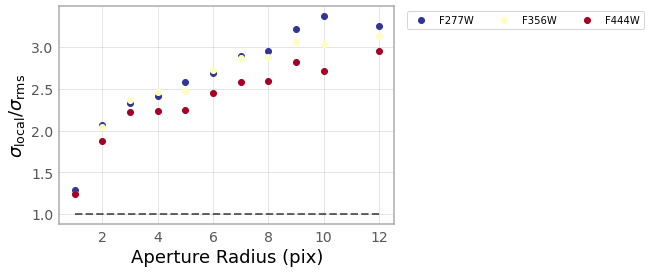

In [3]:
%matplotlib inline
galaxy.derive_rms_correction_factor(
        region_area_pix=5,
        bands=['F090W', 'F115W', 'F150W', 'F162M', 'F182M', 'F200W', 'F210M',
                'F250M', 'F277W', 'F300M', 'F335M', 'F356W', 'F410M', 'F444W'],
        cutout_size=3000,
        overwrite=True,
        plot=True,
        plot_debug=False,
        scatter_size=0.1,
        distance_to_mask=30,
        radii_to_check=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12],
        n_nearest=5000,
        min_correction=1);


There's also the galaxy.estimate_rms_from_background, which compares the RMS map to the true RMS of pixels identified as the background by dilating the segmentation map.

The below histograms show the a histogram of RMS pixels in blue, a histogram of background pixels in black, with the red vertical line showing the RMS of the black distribution. A red line with a larger value than the blue histogram peak would suggest the RMS map is underestimated. 

 added to <HDF5 file "JOF_16.h5" (mode r+)>, meta, rms_background


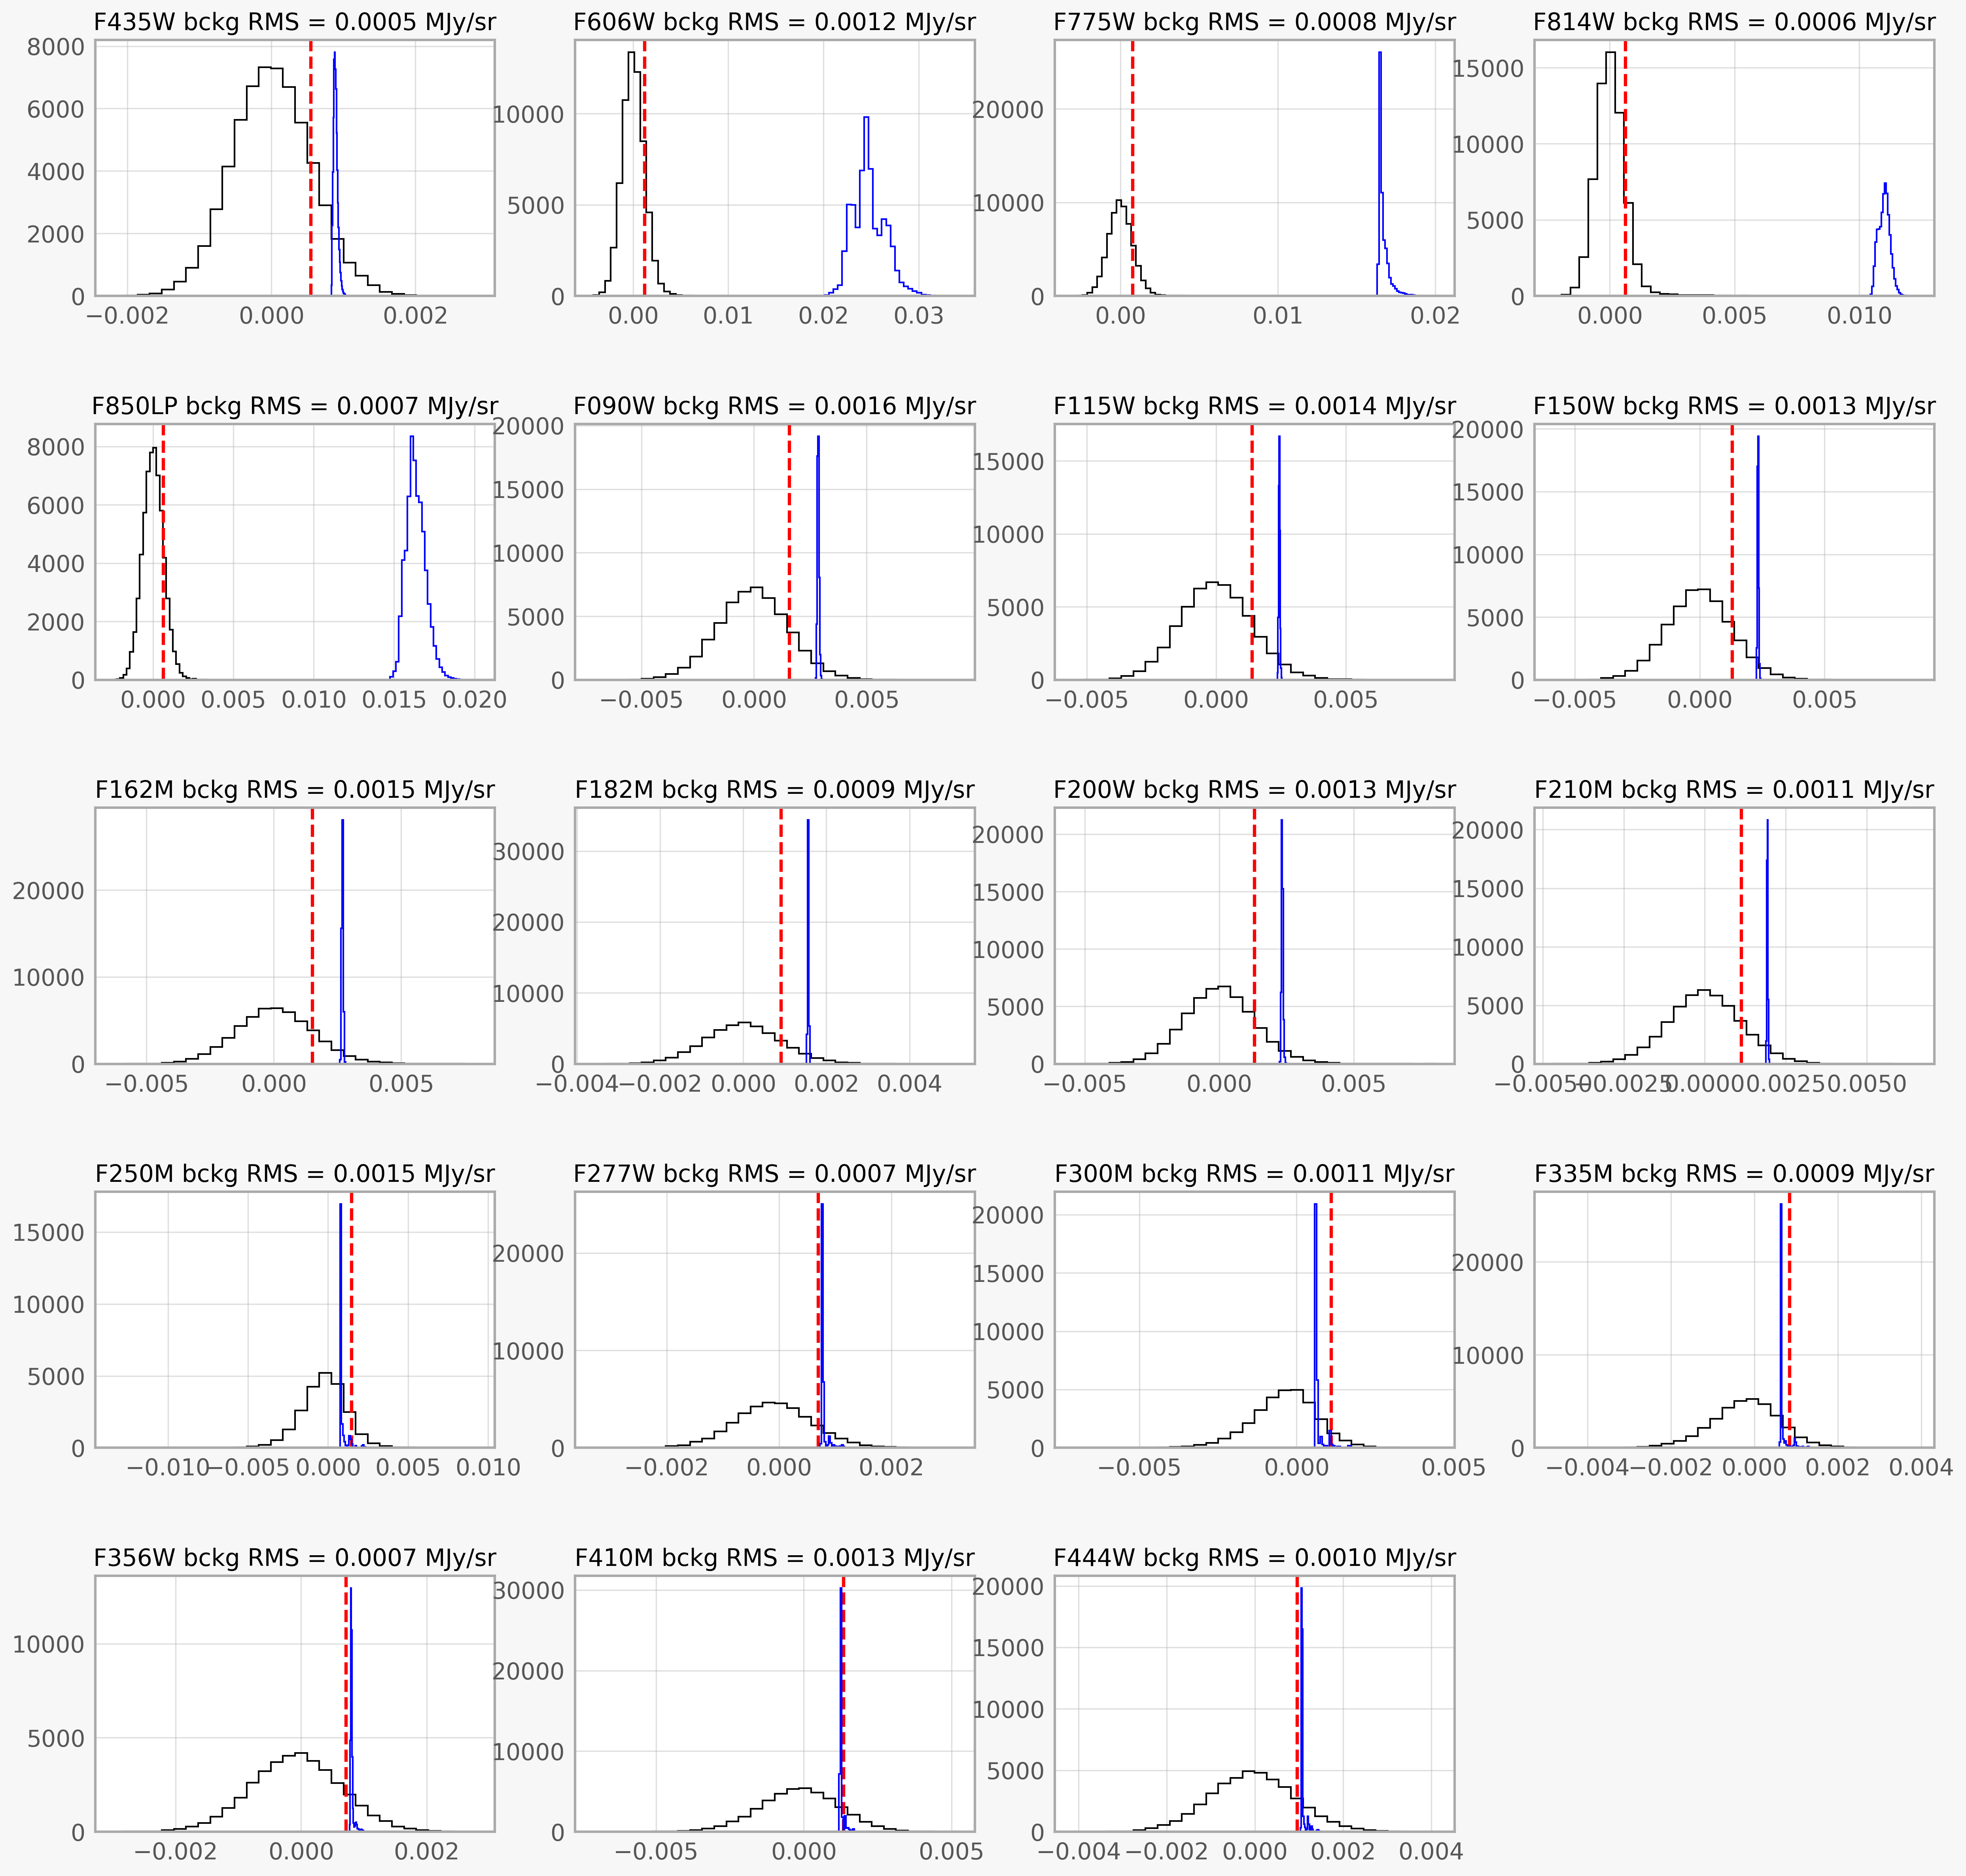

In [6]:
galaxy.estimate_rms_from_background(cutout_size=250, object_distance=20, overwrite=True, plot=True)

### Pixel Binning

A common step in resolved SED fitting is to bin the pixels in some way. EXPANSE supports many different kinds of binning, and you can also directly set your own bin maps if you wish.

We differentiate between a galaxy region, which is typically a boolean pixel masking defining the region of the galaxy, and a bin map, which is an integer map defining the bin number of each pixel.

Here is a simple example of a galaxy region - simply selecting all individual pixels above a set RMS SNR threshold.
You can name the region, and set the SNR threshold, choose which band is used and also supply a mask, if you want to mask out certain regions of the image.

In [12]:
galaxy.pixel_by_pixel_galaxy_region(snr_req=3)

galaxy.pixel_by_pixel_galaxy_region(snr_req=5, band_req='F277W', region_name='SNR_5_F277W')

SNR_3_F444W already exists in galaxy_region group and overwrite is set to False
 added to <HDF5 file "JOF_16.h5" (mode r+)>, galaxy_region, SNR_5_F277W


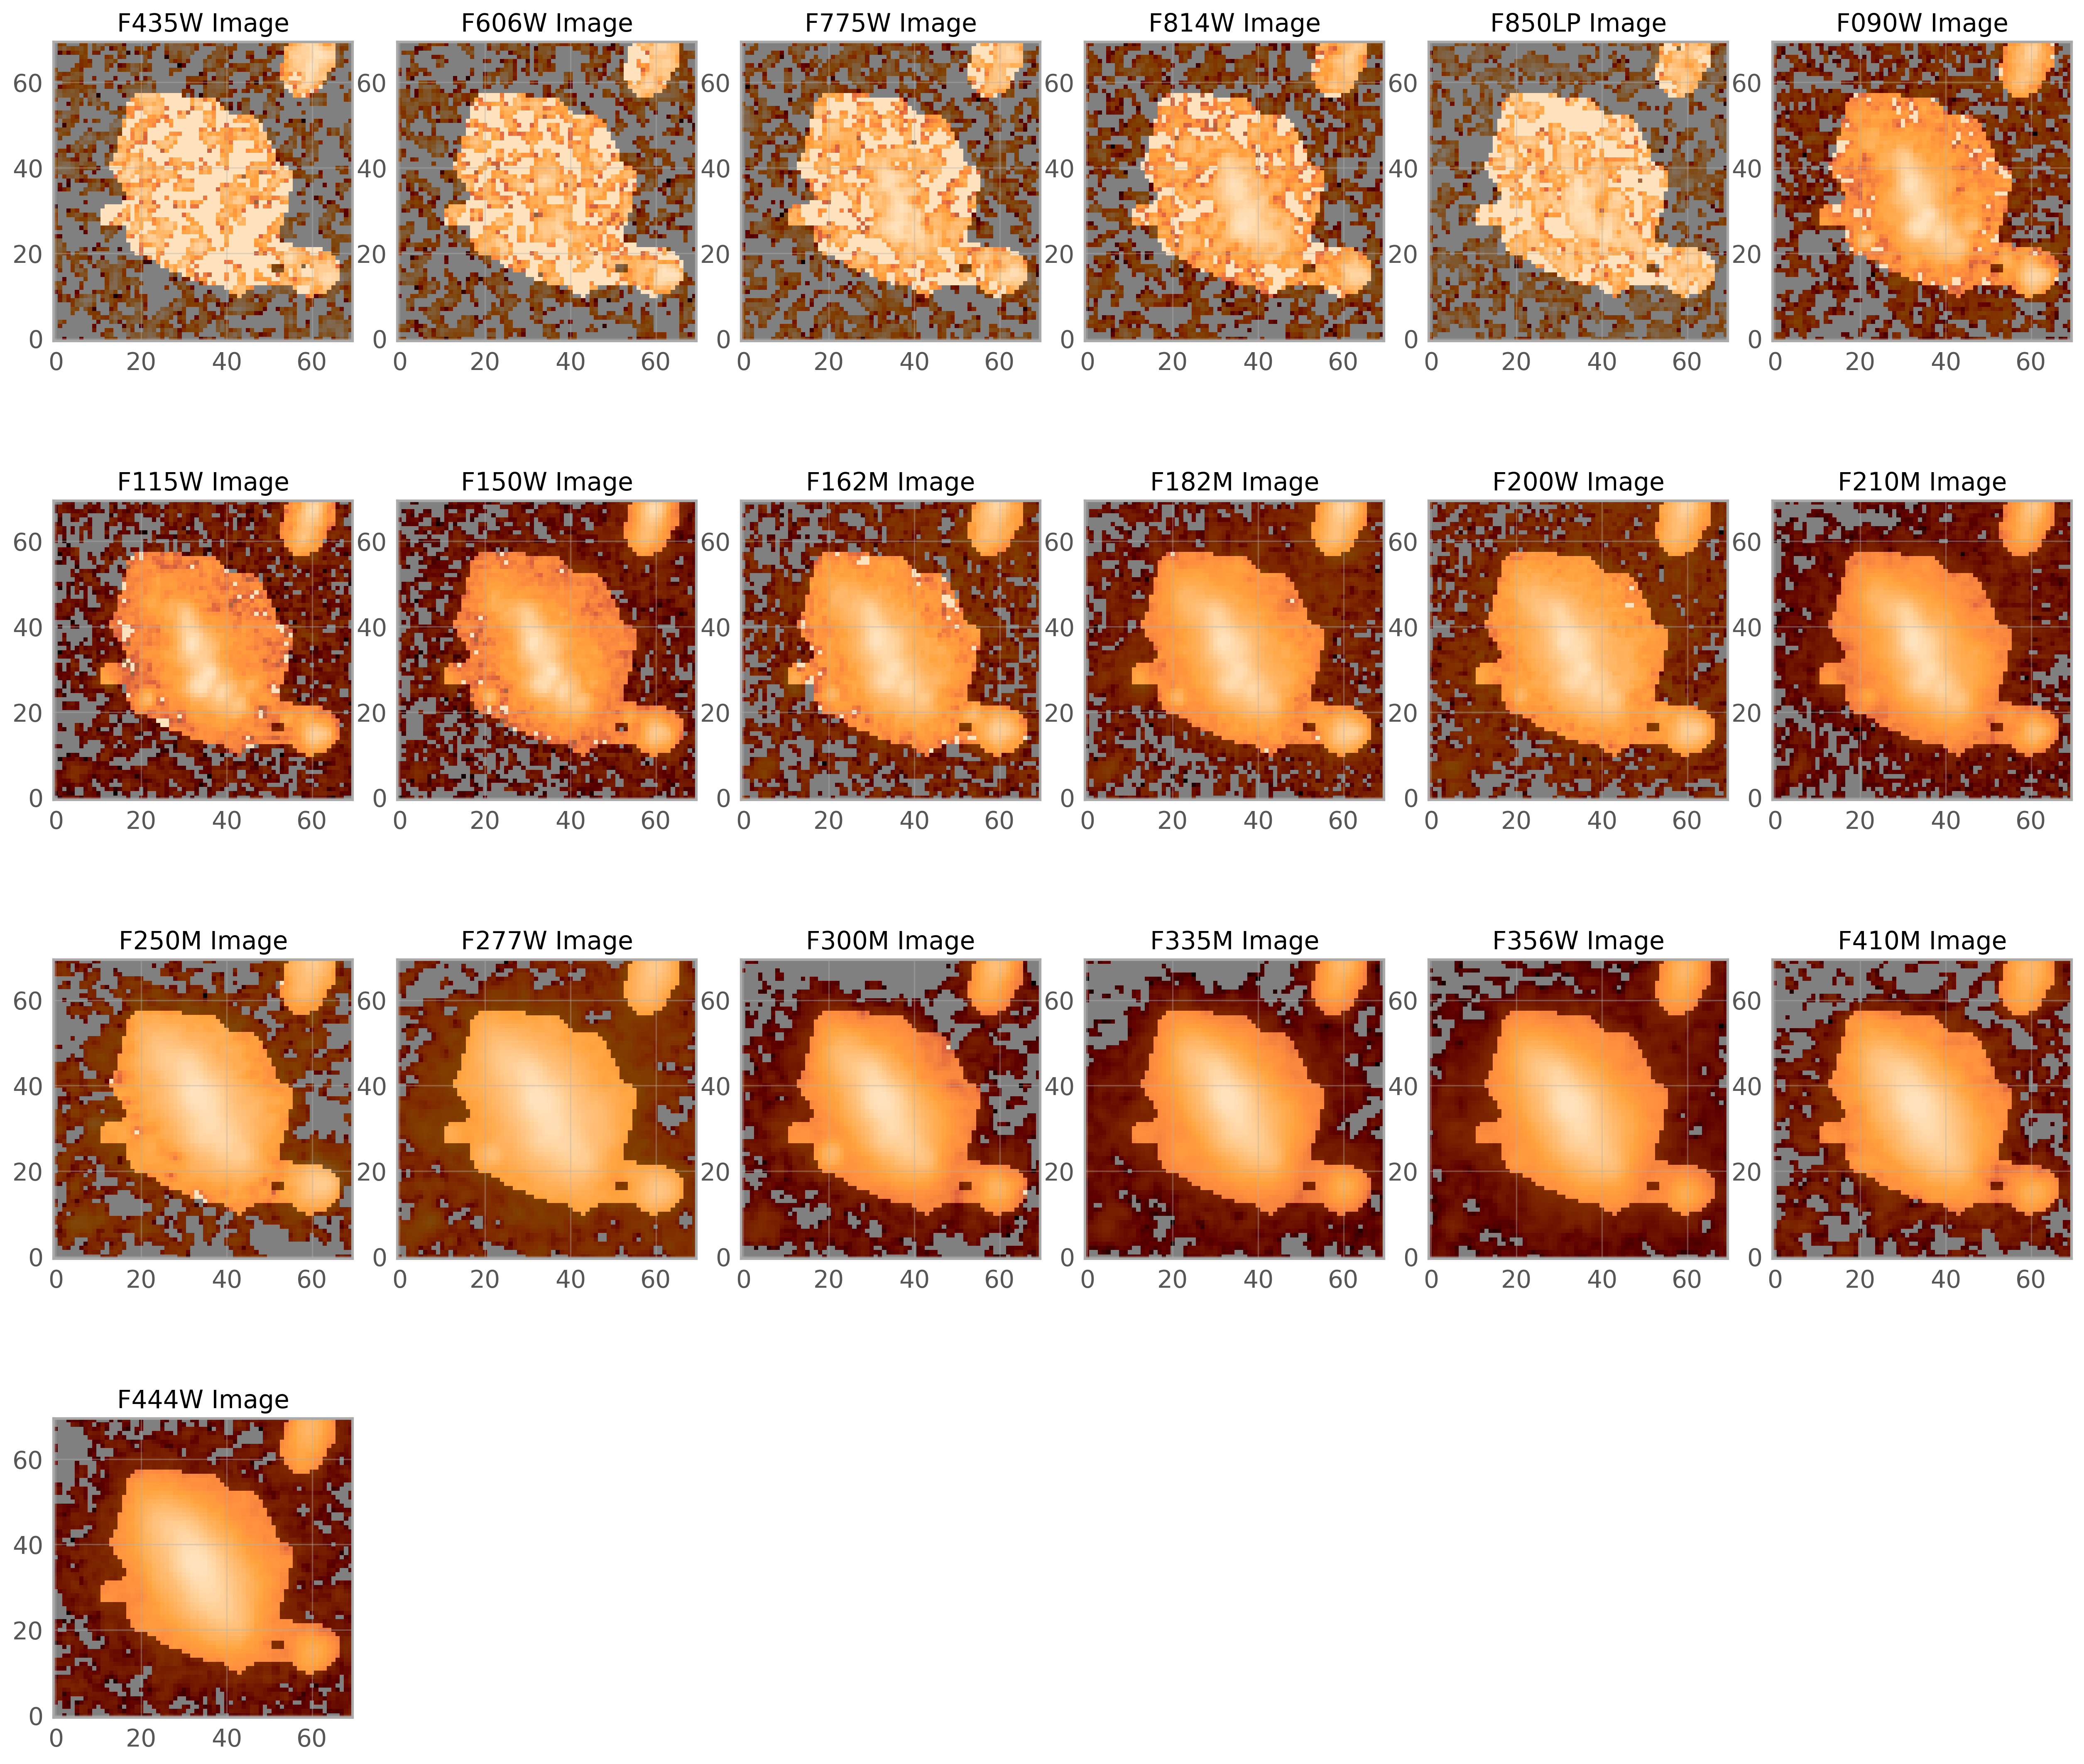

In [14]:
galaxy.plot_gal_region('SNR_5_F277W');

Segmentation maps in any band or stack of bands can also be used to define galaxy regions. The code will typically assume the segmentated region at the center of the cutout is the galaxy region.

These don't have to be seperately defined and can be named directly when binning.

The galaxy regions are stored in self.gal_region, so any method can add new bin methods here and then call dump_to_h5 to save the new regions.

In [16]:
print(galaxy.gal_region)

{'SNR_3_F444W': array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'SNR_5_F277W': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])}


This will then perform the binning, and store the bin map in the HDF5 file. This binning is the simplest case, as each non-zero pixel in the galaxy region is assigned a unique bin number. e.g. 1, 2, 3 etc.


In [7]:
galaxy.pixel_by_pixel_binmap(galaxy_region = 'SNR_3_F444W', overwrite=True)

 added to <HDF5 file "JOF_16.h5" (mode r+)>, bin_maps, pixel_by_pixel
Setting pixel_by_pixel_map attribute.


Then we come to actually measuring the flux in the bins. You set the binmap type to one of the bin maps used for binning, and the code will measure the flux in each bin and store it in an astropy Table within the HDF5 file. You can also set which PSF model is used, but it will default to the one set in the init if you don't.

One important thing you can do is turn on the correction for correlated noise, which will either run or fetch the stored results of galaxy.derive_rms_correction_factor and apply it to the flux errors for each bin and each band. It does not currently have an affect on the total fluxes however (e.g. MAG_AUTO, MAG_APER etc).

In [3]:
tab = galaxy.measure_flux_in_bins(binmap_type='pixel_by_pixel', overwrite=True, correct_errors_for_correlated_noise=True)

Correcting binned pixel errors for correlated noise.
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1 1
F435W 1

Here is the photometry table that has been stored below. Note that you can control which photometry is measured. By default we include each bin, as well as the sum of all bins (TOTAL_BIN), and available photometry types (e.g. AUTO, ISO, etc).


In [4]:
galaxy.photometry_table['star_stack']['pixel_by_pixel']

<QTable length=2160>
         ID                  type         ...       F444W_err       
                                          ...          uJy          
       str20                str20         ...        float64        
-------------------- -------------------- ... ----------------------
                   1                  bin ... 2.2477002858067863e-05
                   2                  bin ... 2.3330323529080488e-05
                   3                  bin ... 2.2692885977448896e-05
                   4                  bin ... 2.3080809114617296e-05
                   5                  bin ...  2.259756365674548e-05
                   6                  bin ... 2.2584024918614887e-05
                   7                  bin ... 2.3438378775608726e-05
                   8                  bin ...  2.294600199093111e-05
                   9                  bin ... 2.2829521185485646e-05
                 ...                  ... ...                    ...
                2152                  bin ... 2.3505612261942588e-05
                2153                  bin ...  2.307941031176597e-05
                2154                  bin ... 2.2852969777886756e-05
                2155                  bin ...  2.271882476634346e-05
           TOTAL_BIN            TOTAL_BIN ...  0.0011290925088434356
      TOTAL_BIN_TEST       TOTAL_BIN_TEST ...   0.006558554926664751
            MAG_AUTO             MAG_AUTO ...                    0.0
MAG_APER_0.32 arcsec MAG_APER_0.32 arcsec ...  0.0005638863042774126
      MAG_APER_TOTAL       MAG_APER_TOTAL ...  0.0005638863042774126

### Plotting overview


Here is a function that lets you plot the photometry, cutouts, binmap etc on one figure. You can customize which photometry to show, as well as the which cutouts and how the RGB is made.

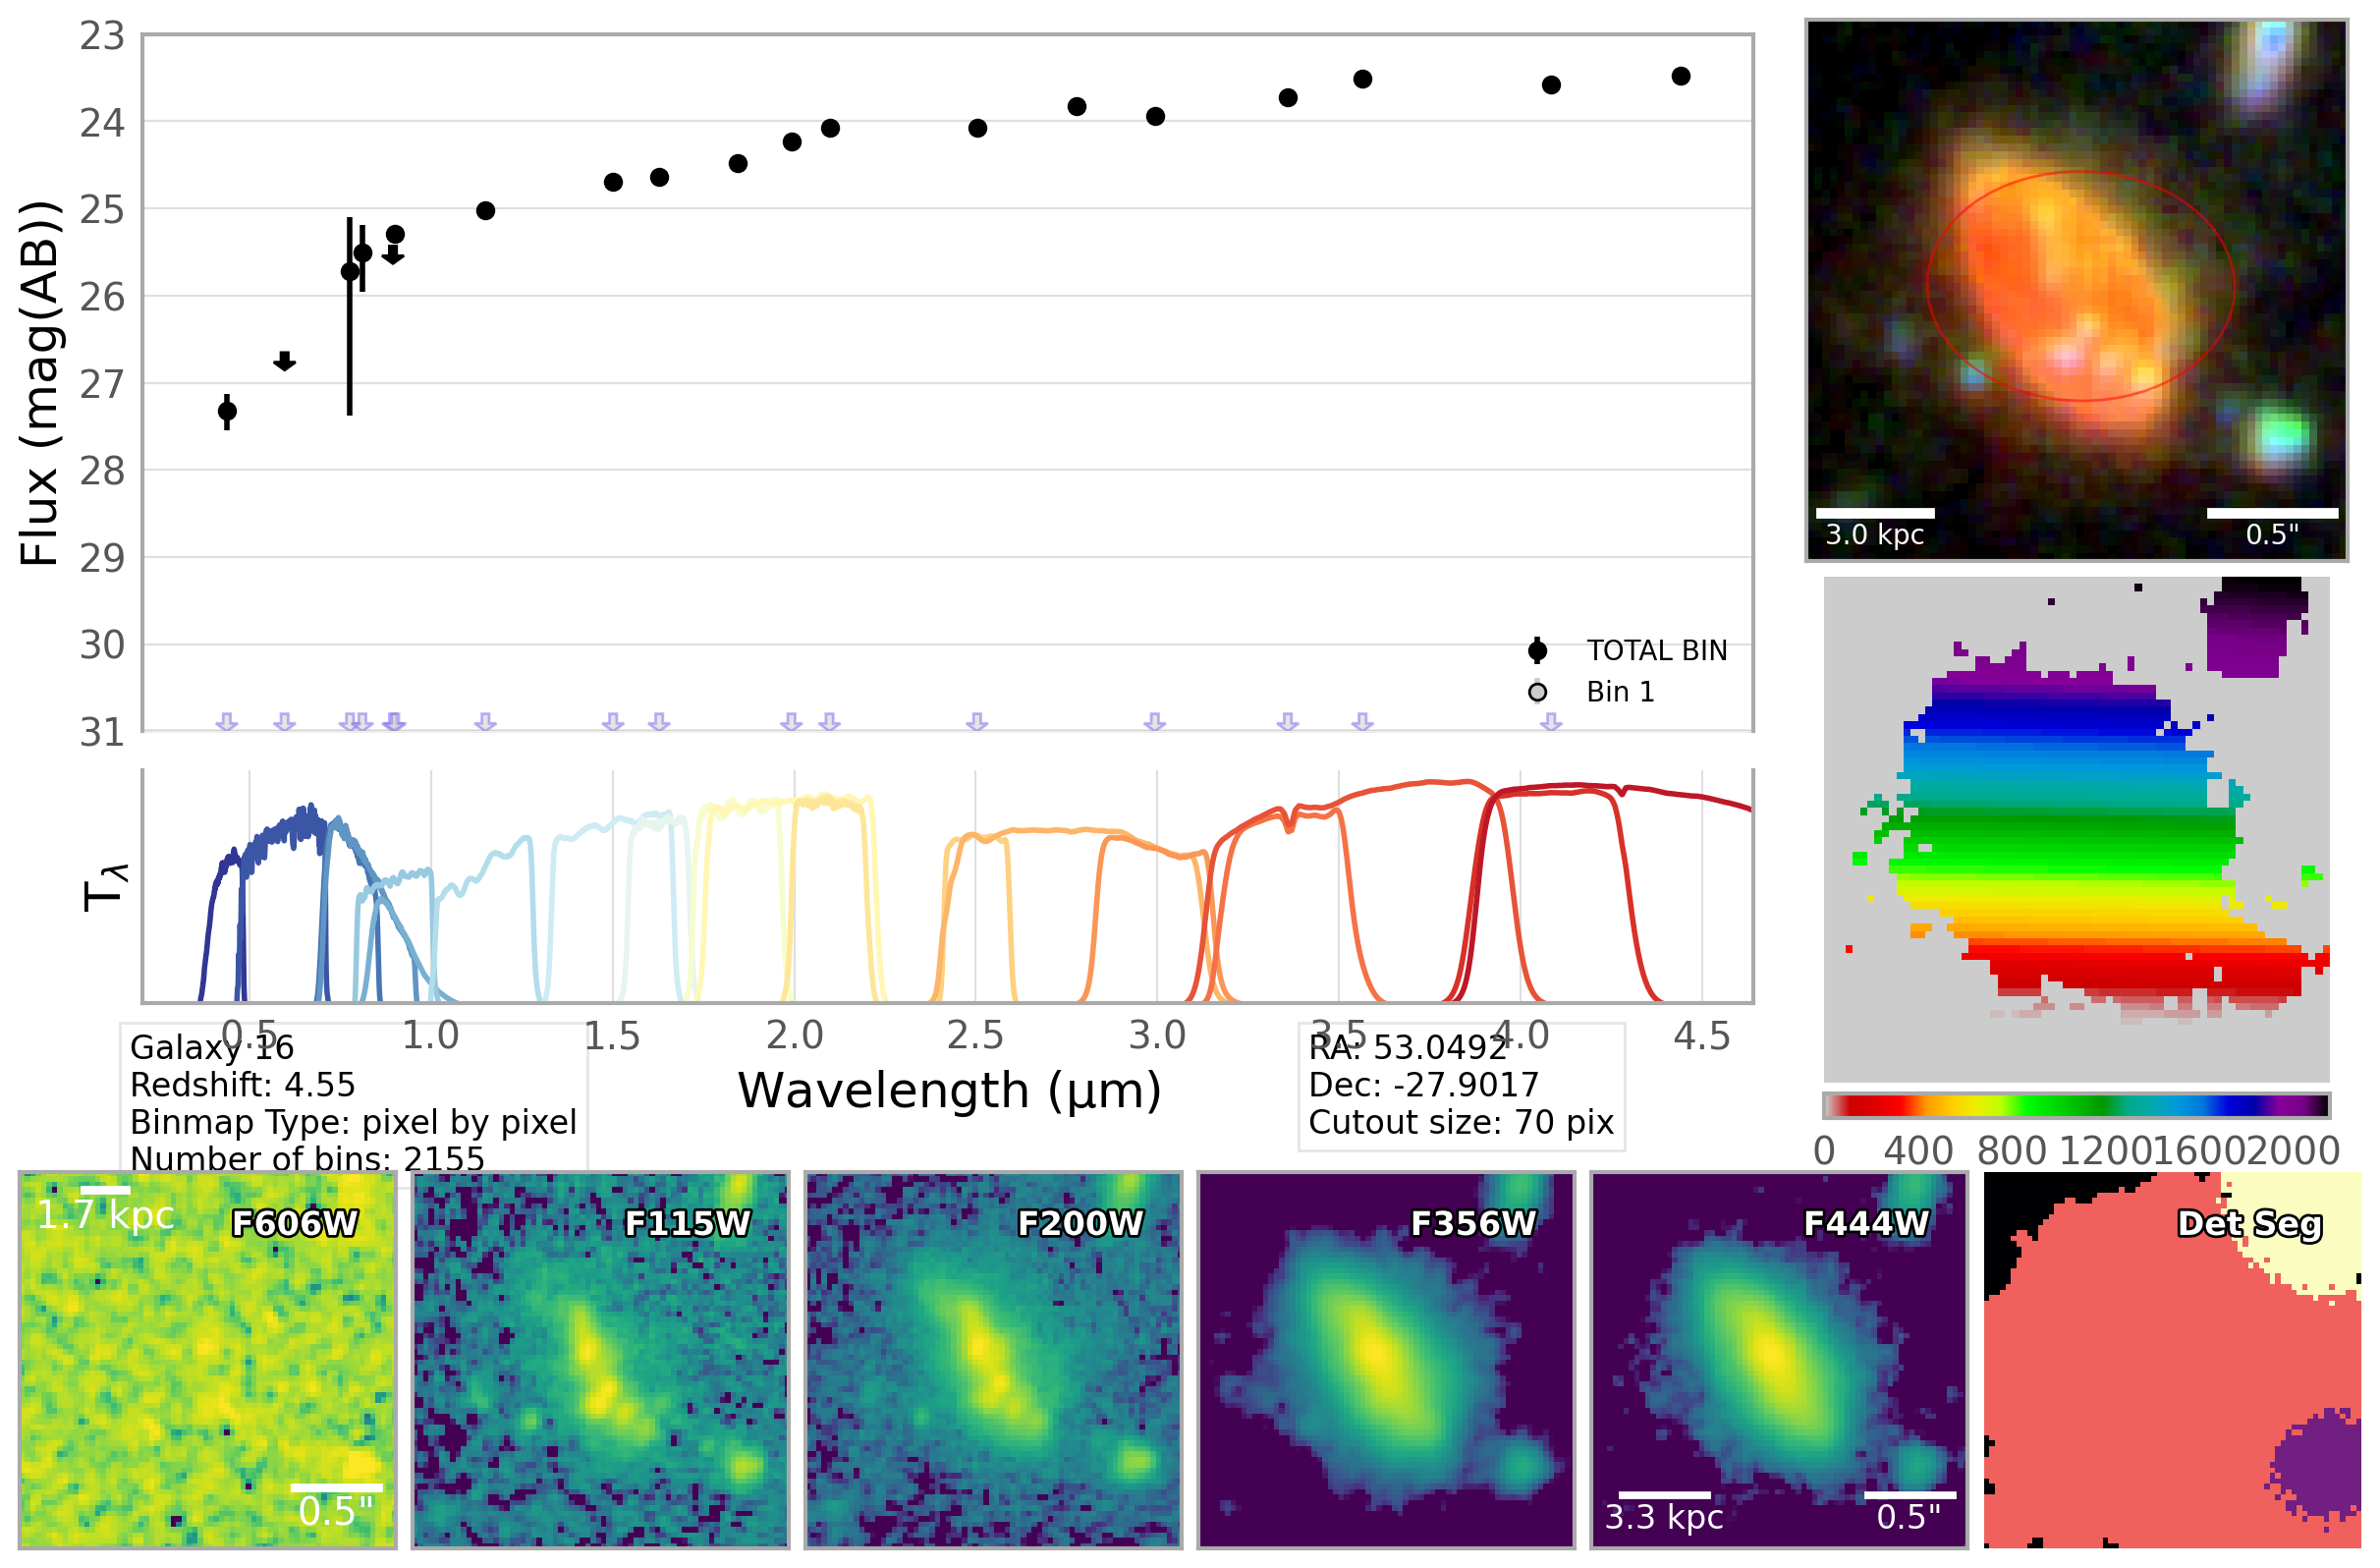

In [10]:
%matplotlib inline
galaxy.plot_overview(save=False, flux_unit = u.ABmag, show=True, binmap_type = 'pixel_by_pixel',
                    bins_to_show = ["TOTAL_BIN", "1"],
                    bands_to_show = ['F606W', 'F115W', 'F200W', 'F356W', 'F444W'], max_sed_flux=23*u.ABmag);

### Interaction with piXedfit

piXedfit is a package for fitting SEDs to resolved data, available [here](https://pixedfit.readthedocs.io/en/latest/). EXPANSE is designed to work with piXedfit's binning module, and the output of the piXedfit functions could be used to perform SED fitting with piXedfit, although this is not directly supported.

The first function is pixedfit_processing, which generates the initial inputs for piXedfit. You can set which galaxy region you want to use as an input for the binning.

In [ ]:
galaxy.pixedfit_processing(gal_region_use='SNR_5_F277W')

Then we can perform the actual binning. piXedfit contains a binning routine which tries to group pixels with similar SEDs together, until an SNR threshold is met. Note that currently the correlated noise correction is not applied during this binning process, so the SNR may be underestimated. You can set the SNR threshold, the minimum radius of a bin, and the band the iniitial pixel is chosen from (based on the brightest unbinned pixel.)

In [ ]:
galaxy.pixedfit_binning()

### Voronoi Binning

Voronoi tesselation using the [vorbin package](https://pypi.org/project/vorbin/) is supported. You can set which band(s) the SNR requirement is calculated from, or you can leave it semi-automated to calculate from the galaxy redshift (only bands redward of Lyman break). You can control if only widebands are used, and which instrument (e.g. NIRCam only). You can also set the output name to save multiple voronoi bin maps.

Here's an example of an average pixel SNR>7 across NIRCam wideband photometry using one of the galaxy regions we made earlier. Note this galaxy region isn't great as it has included the neighboring sources. You may have to play with your deblending settings in sep, or otherwise provide a manual mask when generating the galaxy region.  

start F444W
No use bins: ['F435W', 'F435W', 'F606W', 'F606W', 'F775W', 'F814W', 'F850LP']


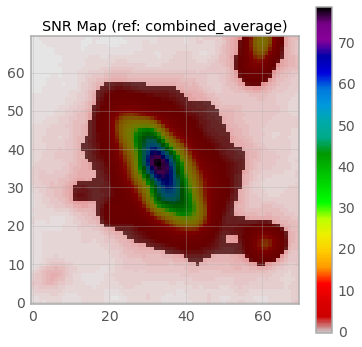

Total SNR of input image: 569.372305728924
Number of pixels: 1804
Number of bins: 1112
Setting meta, ref_band, combined_average
Setting meta, SNR_reqs, 7
Setting meta, psf_type, star_stack
Setting meta, wvt, True
Setting meta, cvt, True
Setting meta, use_only_widebands, False
Setting meta, min_band, auto
Setting meta, band_instrument, NIRCam
Setting meta, min_snr_wav, 1216.0 Angstrom
Setting meta, no_use_bins, ['F435W', 'F435W', 'F606W', 'F606W', 'F775W', 'F814W', 'F850LP']
 added to <HDF5 file "JOF_16.h5" (mode r+)>, bin_maps, voronoi
Setting voronoi_map attribute.


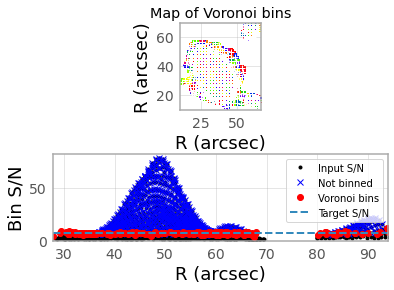

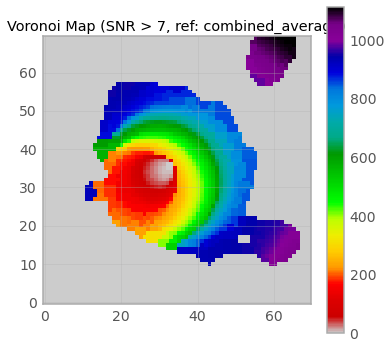

In [28]:
galaxy.voronoi_binning(galaxy_region = 'SNR_5_F277W', SNR_reqs=7,  ref_band='combined_average', min_band='auto', band_instrument='NIRCam', min_snr_wav=1216 * u.Angstrom)

### SED Fitting with Bagpipes

In [ ]:
galaxy.run_bagpipes()

Plotting of SED Results

In [ ]:
galaxy.plot_bagpipes_fit

galaxy.plot_bagpipes_sed

galaxy.plot_bagpipes_corner

galaxy.plot_bagpipes_map_gif

galaxy.plot_bagpipes_component_comparison

galaxy.plot_bagpipes_sfh

### SED Fitting with Dense Basis

[Dense Basis](https://dense-basis.readthedocs.io/) is a SED fitting code which uses the Dense Basis method and Gaussian Processes to generate flexible star formation histories and apply them to SED fitting using fsps.

EXPANSE supports Dense Basis SED fitting and plotting results, and includes functions inside EXPANSE.dense_basis to generate the initial dictionary of SEDs, which can take considerable time (hours to days), but must only be done once (for a given prior and filter set choice). 

We have provided a helper function called make_db_grid, which lets you set parameter priors and a list of filters and handles generating the grid. 

In [29]:
?galaxy.run_dense_basis(db_atlas_path='/nvme/scratch/work/tharvey/EXPANSE/scripts/pregrids/db_atlas_JOF_500000_Nparam_3.dbatlas', plot=True,
                        fit_photometry='TOTAL_BIN')

Signature:
galaxy.run_dense_basis(
    db_atlas_path,
    fit_photometry='all',
    overwrite=False,
    use_emcee=False,
    emcee_samples=10000,
    plot=False,
    n_jobs=4,
    binmap_type=None,
    min_flux_err=0.1,
    priors=None,
    save_outputs=True,
    fix_redshift=False,
    save_full_posteriors=False,
    save_spectra=False,
    save_sfh=False,
    parameters_to_save=['mstar', 'sfr', 'Av', 'Z', 'z'],
    verbose=True,
)
Docstring: <no docstring>
File:      /nvme/scratch/work/tharvey/EXPANSE/src/EXPANSE/ResolvedGalaxy.py
Type:      method

### Morphological Fitting with pysersic

Here we demonstrate how to use pysersic to fit a morphological model to the galaxy. You can choose which band to fit in (simulatenous multiband fitting currently not supported), which model to fit (sersic, exponential, psf, sersic+exponential, etc), and optional priors for the fit. Below we fit our galaxy in F444W, with a Sersic model, and a constraint that the center of the Sersic profile is within 5 pixels of the center of the cutout. 

You can also customize the fitting procedure used with the 'fit_type' argument. MVP, posterior (SVI-flow or laplace) and sample (using a NUTS sampler) are all available. 

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 1.46, sigma = 2.42
xc ---  Uniform between: 30.00 -> 40.00
yc ---  Uniform between: 30.00 -> 40.00
r_eff ---  Truncated Normal w/ mu = 8.29, sigma = 5.76, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Uniform between: 0.65 -> 8.00

Sky Type: none



  3%|▎         | 253/10000 [00:00<00:13, 708.09it/s, Round = 2,step_size = 1.0e-04 loss: -3.491e+04]


{'xc': 32.6875, 'yc': 34.0279, 'flux': 1.28605, 'r_eff': 8.2723, 'n': 0.650279, 'ellip': 0.620307, 'theta': 2.12553, 'model': array([[4.2441757e-06, 4.3939808e-06, 4.6729683e-06, ..., 4.6430514e-06,
        4.4278008e-06, 4.3174937e-06],
       [4.6729642e-06, 4.8372999e-06, 5.1054685e-06, ..., 4.8441170e-06,
        4.7165877e-06, 4.6892096e-06],
       [5.2127812e-06, 5.3582103e-06, 5.6026101e-06, ..., 5.2348787e-06,
        5.1873812e-06, 5.2165278e-06],
       ...,
       [4.0664459e-06, 3.9777015e-06, 4.0797213e-06, ..., 4.9753439e-06,
        4.5452775e-06, 4.1900566e-06],
       [3.9871534e-06, 3.9945867e-06, 4.1904177e-06, ..., 4.6733094e-06,
        4.3048312e-06, 4.0223476e-06],
       [4.0848008e-06, 4.1802418e-06, 4.4396961e-06, ..., 4.5186812e-06,
        4.2225174e-06, 4.0266746e-06]], dtype=float32)}


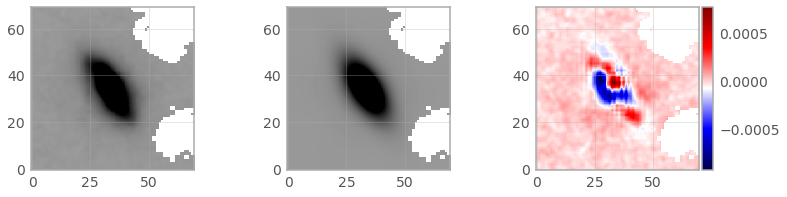

Setting meta, model_type, sersic
Setting meta, psf_type, star_stack
Setting meta, band, F444W
Setting meta, mask_type, seg_F444W
Setting meta, sky_type, none
Setting meta, posterior_method, laplace
Setting meta, rkey, 1000
Setting meta, sample_kwargs, {}
Setting meta, loss_function, student_t
Setting meta, results, {'xc': 32.6875, 'yc': 34.0279, 'flux': 1.28605, 'r_eff': 8.2723, 'n': 0.650279, 'ellip': 0.620307, 'theta': 2.12553}
Setting meta, posterior_sample_method, median
 added to <HDF5 file "JOF_16.h5" (mode r+)>, pysersic/F444W_sersic_star_stack_mvp/, model


In [16]:
%matplotlib inline

galaxy.run_pysersic(
        model_type="sersic",
        psf_type="star_stack",
        use_psf_matched_data=True,
        output_dir=None,
        band="F444W",
        show_plots=True,
        mask_type="seg_F444W",
        make_diagnostic_plots=True,
        save_plots=False,
        fit_type="mvp",
        posterior_sample_method="median",
        overwrite=True,
        force=True,
        prior_dict={
            "xc": {
                "type": "uniform",
                "low": -10,
                "high": 10,
                "relative_to_centre": True,
            },
            "yc": {
                "type": "uniform",
                "low": -10,
                "high": 10,
                "relative_to_centre": True,
            },
        },
    )


The results are saved to the HDF5 file as usual, including the parameter used. You can access the results in the galaxy.pysersic_results dictonary, including the model itself. Below is a an example comparing the data, model and residual, showing a potentail point source and maybe a bar-like component.

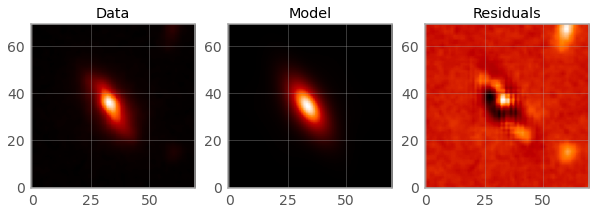

In [15]:
%matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].set_title('Data')
axs[0].imshow(galaxy.psf_matched_data['star_stack']['F444W'], origin='lower')
axs[1].set_title('Model')
axs[1].imshow(galaxy.pysersic_results['F444W_sersic_star_stack_mvp']['model'], origin='lower')
axs[2].set_title('Residuals')
axs[2].imshow(galaxy.psf_matched_data['star_stack']['F444W'] - galaxy.pysersic_results['F444W_sersic_star_stack_mvp']['model'], origin='lower')

plt.show()

### EAZY SED Fitting

EXPANSE supports SED fitting for photo-z's with EAZY-py. You can set which photometry to fit, what EAZY templates to use, whether to exclude any bands, and a minimum flux error. After the first run the default behaviour will cache the template filter array to disk to speed up future fits. You can control this with the  save_tempfilt, load_tempfilt and save_tempfilt_path arguments.

In [24]:
galaxy.eazy_fit_measured_photometry(phot_name='MAG_APER_TOTAL', override_binmap_type='pixel_by_pixel', plot=True)


Zeropoint: 23.9
{'TEMPLATES_FILE': '/nvme/scratch/work/tharvey/EAZY/inputs/scripts/templates/LarsonTemplates/tweak_fsps_QSF_12_v3_newtemplates.param', 'FILTERS_RES': '/nvme/scratch/work/tharvey/EXPANSE/src/EXPANSE/eazy/jwst_nircam_FILTER.RES', 'MW_EBV': 0, 'CAT_HAS_EXTCORR': False, 'ADD_CGM': False, 'Z_STEP': 0.01, 'Z_MIN': 0.01, 'Z_MAX': 20.0, 'TEMP_ERR_FILE': '/nvme/scratch/work/tharvey/EXPANSE/src/EXPANSE/eazy/TEMPLATE_ERROR.eazy_v1.0', 'TEMP_ERR_A2': 0, 'SYS_ERR': 0, 'APPLY_PRIOR': 'n', 'PRIOR_ABZP': 23.9, 'PRIOR_FILTER': 28, 'PRIOR_FILE': '', 'FIX_ZSPEC': False, 'IGM_SCALE_TAU': 1.0, 'N_MIN_COLORS': 2, 'CATALOG_FILE': '/tmp/tmp7_t959_w/eazy_input.fits'}
/nvme/scratch/work/tharvey/EXPANSE/src/EXPANSE/eazy/tempfilt//JOF_fsps_larson_0.01_20.0_0.01_tempfilt.pkl
Read default param file: /nvme/scratch/software/anaconda3/envs/tharvey_galfind/lib/python3.10/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: /tmp/tmp7_t959_w/eazy_input.fits
   >>> NOBJ = 1
F22 E22 ( 22): hst/AC

100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


Template   0: fsps_QSF_12_v3_001.dat (NZ=1).
Template   1: fsps_QSF_12_v3_002.dat (NZ=1).
Template   2: fsps_QSF_12_v3_003.dat (NZ=1).
Template   3: fsps_QSF_12_v3_004.dat (NZ=1).
Template   4: fsps_QSF_12_v3_005.dat (NZ=1).
Template   5: fsps_QSF_12_v3_006.dat (NZ=1).
Template   6: fsps_QSF_12_v3_007.dat (NZ=1).
Template   7: fsps_QSF_12_v3_008.dat (NZ=1).
Template   8: fsps_QSF_12_v3_009.dat (NZ=1).
Template   9: fsps_QSF_12_v3_010.dat (NZ=1).
Template  10: fsps_QSF_12_v3_011.dat (NZ=1).
Template  11: fsps_QSF_12_v3_012.dat (NZ=1).
Template  12: binc100z001age6_cloudy.dat (NZ=1).
Template  13: binc100z001age65_cloudy.dat (NZ=1).
Template  14: binc100z001age7_cloudy.dat (NZ=1).
Template  15: binc100z001age6.dat (NZ=1).
Template  16: binc100z001age65.dat (NZ=1).
Template  17: binc100z001age7.dat (NZ=1).
Process templates: 10.676 s


304it [00:00, 21338.63it/s]

Saving tempfilt to /nvme/scratch/work/tharvey/EXPANSE/src/EXPANSE/eazy/tempfilt/



100%|██████████| 304/304 [00:00<00:00, 4477.49it/s]


Compute best fits
fit_best: 0.0 s (n_proc=1,  NOBJ=1)
Fit 0.2 s (n_proc=4, NOBJ=1)
Setting meta, id_phot, 0
Setting meta, z_best, 4.5199046
Setting meta, chi2, 78.76284799323477
Setting meta, z16, 4.4861917
Setting meta, z50, 4.5194664
Setting meta, z84, 4.5498667
Setting meta, flux_unit, uJy
Setting meta, wave_unit, Angstrom
Setting meta, templates_file, /nvme/scratch/work/tharvey/EAZY/inputs/scripts/templates/LarsonTemplates/tweak_fsps_QSF_12_v3_newtemplates.param
Setting meta, z_min, 0.01
Setting meta, z_max, 20.0
Setting meta, z_step, 0.01
Setting meta, region, MAG_APER_TOTAL_fsps_larson_0.05
 added to <HDF5 file "JOF_16.h5" (mode r+)>, interactive_outputs/MAG_APER_TOTAL_fsps_larson_0_05/, eazy_fit
 added to <HDF5 file "JOF_16.h5" (mode r+)>, interactive_outputs/MAG_APER_TOTAL_fsps_larson_0_05/, p_z
 added to <HDF5 file "JOF_16.h5" (mode r+)>, interactive_outputs/MAG_APER_TOTAL_fsps_larson_0_05/, input_flux
 added to <HDF5 file "JOF_16.h5" (mode r+)>, interactive_outputs/MAG_APER_T

TypeError: ResolvedGalaxy.plot_eazy_fit() missing 2 required positional arguments: 'ez' and 'id'